<a href="https://colab.research.google.com/github/rajunod/cookbooks_various/blob/main/NOAA_climo_percentiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workflow for Displaying Percentiles from CPC Data**

<img src = "https://www.nsstc.uah.edu/data/rjunod/UAH_AOSC_LOGO.png" alt="AOSC logo" width="500">

Example notebook to read in netCDF files of percentile data based on 1991-2020 reference period from NOAA.

>The material in this notebook is licensed for free and open consumption and resuse. All code is served under [GPUv3](https://www.gnu.org/licenses/gpl-3.0.html#license-text), while all non-code content is licensed under [Creative Commons BY 4.0 (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Please give appropriate credit to the notebook authors (**Rob Junod**) and the **Alabama Office of the State Climatologist**.

## Install dependencies

In [1]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 74.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.6 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102771 sha256=4861dfc330735ad7ad13363e6fc6b8f3c49ca39071676928e482d11a56965703
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy


## Import Necessary Packages and Functions

**<font color='red'> Do not change </font>**

In [2]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import fsspec

In [3]:
def var_read_plot(url:str, var_type:str, unit:str, ptile:int, time_step:str,
                  date:str, smooth: bool = False)-> xr.Dataset:
    """ Function to readin CPC percentile data given user inputs and plot

    Parameters
    -----------
    :param url: ftp directory of CPC data
    :param var_type: variable type (tmax,tmin,tmean,precip,swe,wmax)
    :param ptile: percentile
    :param time_step: time_step for percentiles (1day,3day,4day,5day,7day,14day)
    :param date: date for percentiles
    :param unit: prefered unit of output (C, F, mm, in, m/s, mph)
    :param smooth: True/False for smooth data, defaults to False

    Returns
    --------
    :returns: view of xarray dataset

    Notes
    ------
    If time_step is multi-day, date represents the end date of the aggregation
    """
    tstep = {'1-Day':'01d',
            '3-Day':'03d',
            '4-Day':'04d',
            '5-Day':'05d',
            '7-Day':'07d',
            '14-Day':'14d'}[time_step]

    plabel = {'C': ['Temperature ($^\circ$C)','RdBu_r'],
              'F': ['Temperature ($^\circ$F)','RdBu_r'],
              'mm': ['Millimeters','BrBG'],
              'in': ['Inches','BrBG'],
              'm/s': ['Meters per Second','cool'],
              'mph': ['Miles per Hour','cool']}[unit]

    units = {'C' : lambda x: x,
             'F' : lambda x: (x*9/5)+32,
             'mm': lambda x: x,
             'in': lambda x: x/25.4,
             'm/s': lambda x: x,
             'mph': lambda x: x*2.237}

    # Get function
    unit_func = units.get(unit)

    _s_str = '' if smooth else '_unsmoothed'

    file = f'{url}/{var_type}/{tstep}/{var_type}_clim_ptiles_{tstep}{_s_str}.nc'
    print(file)

    with fsspec.open(file) as f:
        data = xr.open_dataset(f)
        date = f"{data.date.values.astype('datetime64[Y]')[0]}-{date}"

        # Get min and max values for static plot
        max_val = data.sel(ptile=ptile, latitude=slice(35,30),
                            longitude=slice(271,275))[f'{var_type}'].max()
        min_val = data.sel(ptile=ptile, latitude=slice(35,30),
                            longitude=slice(271,275))[f'{var_type}'].min()

        max_val = unit_func(max_val)
        min_val = unit_func(min_val)

        # Get latitude and longitude values for plotting text values
        lats = data.sel(latitude=slice(35,30),
                        longitude=slice(271,275)).latitude.values
        lons = data.sel(latitude=slice(35,30),
                        longitude=slice(271,275)).longitude.values

        # Subset dataset in degrees F
        data_sub = unit_func(data.sel(ptile=ptile, date = date,
                                      latitude=slice(35,30),
                                      longitude=slice(271,275)
                                      )[f'{var_type}'].copy())

        fig, ax = plt.subplots(figsize=(4.8,8),
                               subplot_kw={'projection':ccrs.PlateCarree()})
        data_sub.plot(ax=ax,
                        vmin=min_val, vmax=max_val,
                        cmap=plabel[1],
                        cbar_kwargs={"label": plabel[0],
                                     "orientation":'horizontal',
                                     "pad":0.01})
        for i in lons:
            for j in lats:
                ax.text(i, j,
                        f'{data_sub.sel(latitude=j,longitude=i).values:.2f}',
                        color='white',
                        ha='center', va='center', transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cf.STATES)
        ax.set_title(f"{time_step} {var_type.upper()} {ptile} "
                     f"Percentile ending on \n"
                     f"{date.split('-')[1]}-{date.split('-')[2]}")
        plt.tight_layout()
    return data


## Read in NOAA Percentile data from FTP site and Plot

For all six variables (`tmax`,`tmin`,`tmean`,`precip`,`swe`,`wmax`), temporal smoothed or unsmoothed percentile data are available. The main FTP directory is located here: https://ftp.cpc.ncep.noaa.gov/climatologies/

---

This example will use the unsmoothed version of `tmax` but can be adapted easily by changing the user input parameters below

### User Input


<font size=4> User change following variables in the next cell to your specifications

`VAR_TYPE` can be **`'tmax', 'tmin', 'tmean', 'precip', 'swe', or 'wmax'`**

`UNITS` can be **`'C', 'F', 'mm', 'in', 'm/s', or 'mph'`** depending on `VAR_TYPE`:
>- **`'C' or 'F'`** for `tmax, tmin, or tmean`
>- **`'mm' or 'in'`** for `precip or swe`
>- **`'m/s' or 'mph'`** for `wmax`

`PERCENTILE` can be **`1,  2,  5, 10, 15, 20, 25, 33, 40, 50, 60, 67, 75, 80, 85, 90, 95, 98, 99`**

`TIME_STEP` can be **`'1-Day', '3-Day', '4-Day', '5-Day', '7-Day', or '14-Day'`**

`DATE_STR` can be a single date or range of dates. See <font color="red">**NOTE**</font> below for more information

`SMOOTH` can be **`True`** for smoothed data or **`False`** for unsmoothed data

> <b><p><font color="red"> NOTE on </font> `DATE_STR`: </p></b>
> - Make sure your `DATE_STR` variable is in the format `'MM-DD'`. The month and day represents the percentile data for that day. Month and day should be zero-padded, e.g. July 1st should **'07-01'** not **'7-1'**.
> - For multiple day aggeration percentile, `DATE_STR` variable has the same format `'MM-DD'` but the date represents the last date of day aggeration.
>   - For example, for a 5 day aggeration from July 1st to July 5th:
      `DATE_STR = "07-05"`
</font>

In [6]:
# Change to your specifications
VAR_TYPE = 'wmax'
UNITS = 'mph'
PERCENTILE = 15
TIME_STEP = '1-Day'
DATE_STR = '07-14'
SMOOTH = False

https://ftp.cpc.ncep.noaa.gov/climatologies/wmax/01d/wmax_clim_ptiles_01d_unsmoothed.nc


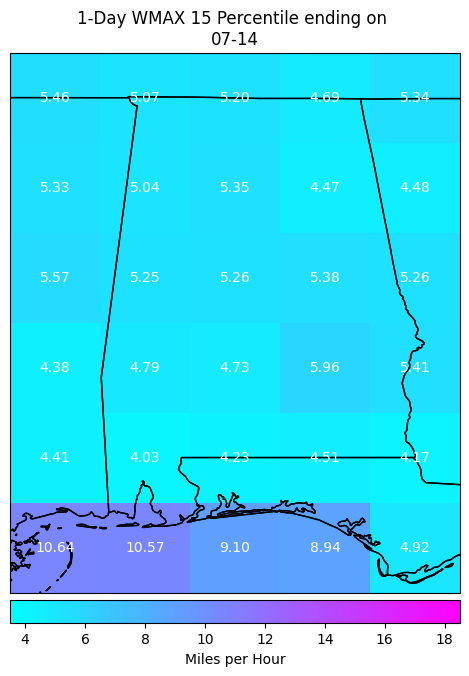

In [7]:
# Main FTP directory for CPC data
URL = 'https://ftp.cpc.ncep.noaa.gov/climatologies'
var_data = var_read_plot(URL,VAR_TYPE,UNITS,PERCENTILE,TIME_STEP, DATE_STR, SMOOTH)

In [8]:
# If you need to look at the data
var_data

<xarray.Dataset>
Dimensions:    (date: 366, ptile: 19, latitude: 181, longitude: 360)
Coordinates:
  * latitude   (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * ptile      (ptile) int64 1 2 5 10 15 20 25 33 40 ... 67 75 80 85 90 95 98 99
  * date       (date) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
Data variables:
    wmax       (date, ptile, latitude, longitude) float64 ...
Attributes:
    window:            01d
    years:             [1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 200...
    smoothing_window:  31
    contact:           mike.charles@noaa.gov
    comment:           Climatological percentiles are smoothed temporally, ov...